# Get GW170817 data

This is a small notebook to preprocess the GW170817 data. The data is taken from [this link](https://gwosc.org/events/GW170817/), and since we had issues reading the GWF and HDF5 data, we have downloaded the txt files (cleaned data, so after noise subtraction) and preprocess it to fit our needs below.

In [1]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])
import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import tukey
from jimgw.single_event.detector import H1, L1, V1

/home/thibeau.wouters/miniconda3/envs/jim/lib/python3.10/site-packages/lalframe/lalframe.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
trigger_time = 1187008882.43
duration = 128
post_trigger_duration = 2
gps_start = trigger_time - duration + post_trigger_duration
gps_end = trigger_time + post_trigger_duration
tukey_alpha = 2 / (duration / 2)
fmin = 20.0
fmax = 2048.0
data_path = "/home/thibeau.wouters/gw-datasets/GW170817/" # on CIT

## Get data from the txt files

File:  /home/thibeau.wouters/gw-datasets/GW170817/H-H1_LOSC_CLN_16_V1-1187007040-2048.txt
len(data)
1048577
len(freqs)
259583
Finished reading the data.
Checking for NaNs
False
False
Checking if shape is OK?
True
Saving freqs for H1 to /home/thibeau.wouters/gw-datasets/GW170817/H1_freq.txt
Saving data for H1 to /home/thibeau.wouters/gw-datasets/GW170817/H1_data_re.txt
Saving data for H1 to /home/thibeau.wouters/gw-datasets/GW170817/H1_data_im.txt


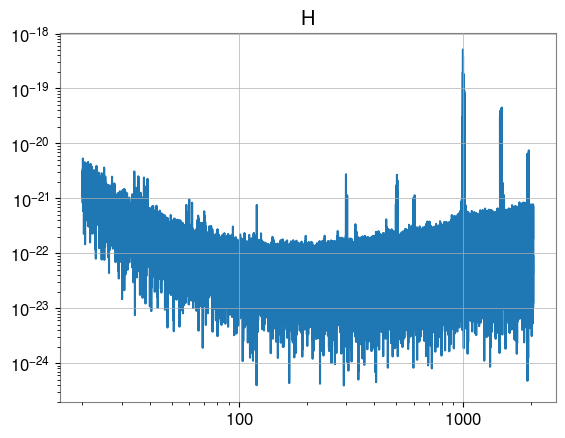

File:  /home/thibeau.wouters/gw-datasets/GW170817/L-L1_LOSC_CLN_16_V1-1187007040-2048.txt
len(data)
1048577
len(freqs)
259583
Finished reading the data.
Checking for NaNs
False
False
Checking if shape is OK?
True
Saving freqs for L1 to /home/thibeau.wouters/gw-datasets/GW170817/L1_freq.txt
Saving data for L1 to /home/thibeau.wouters/gw-datasets/GW170817/L1_data_re.txt
Saving data for L1 to /home/thibeau.wouters/gw-datasets/GW170817/L1_data_im.txt


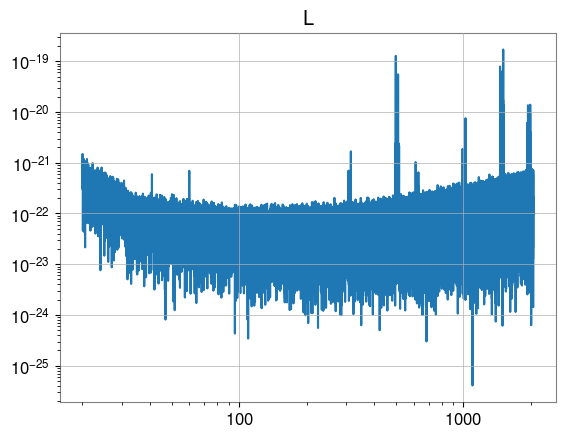

File:  /home/thibeau.wouters/gw-datasets/GW170817/V-V1_LOSC_CLN_16_V1-1187007040-2048.txt
len(data)
1048577
len(freqs)
259583
Finished reading the data.
Checking for NaNs
False
False
Checking if shape is OK?
True
Saving freqs for V1 to /home/thibeau.wouters/gw-datasets/GW170817/V1_freq.txt
Saving data for V1 to /home/thibeau.wouters/gw-datasets/GW170817/V1_data_re.txt
Saving data for V1 to /home/thibeau.wouters/gw-datasets/GW170817/V1_data_im.txt


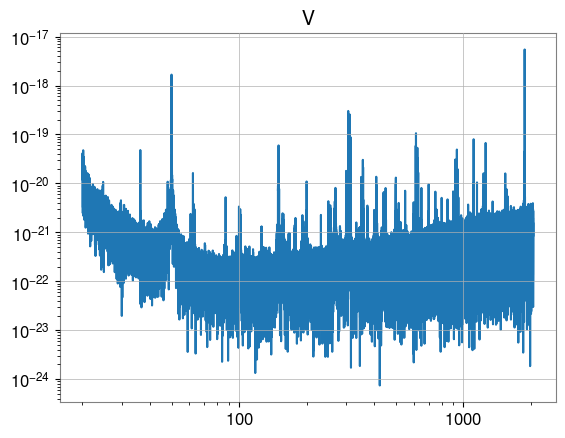

Done


In [18]:
data_freq_name = 16
for detector, name in zip([H1, L1, V1], ["H", "L", "V"]):
    file = f"{data_path}{name}-{name}1_LOSC_CLN_{data_freq_name}_V1-1187007040-2048.txt"   
    
    print("File: ", file)
    data = np.loadtxt(file)
    
    txt_duration = 2048
    f_sampling = 16384
    
    # Get time grid
    dt = 1 / f_sampling
    time = np.linspace(0, txt_duration, f_sampling * txt_duration)
    assert len(time) == len(data), "Something went wrong"
    txt_trigger_time = 1842.43
    # Limit times to be between window and mask data as well
    time_start = txt_trigger_time - duration + 2
    time_end = txt_trigger_time + 2
    ### TODO: apply mask elsewhere?
    mask = (time > time_start) & (time < time_end)
    # time = time[mask]
    data = data[mask]
    
    # Do FFT to get frequencies
    n = len(data)
    data_fd = np.fft.rfft(np.array(data) * tukey(n, tukey_alpha)) * dt
    freq = np.fft.rfftfreq(n, dt)

    print("Finished reading the data.")

    mask = (freq > fmin) & (freq < fmax)
    freq = freq[mask]
    data_fd = data_fd[mask]
    data_fd_re = np.real(data_fd)
    data_fd_im = np.imag(data_fd)
    
    # Check if NaNs somewhere:
    print("Checking for NaNs")
    print(np.isnan(data_fd).any())
    print(np.isnan(freq).any())
    
    print("Checking if shape is OK?")
    print(len(data_fd) == len(freq))
    
    # Save to new txt files to use later on
    save_name = data_path + f"{name}1_freq.txt"
    print(f"Saving freqs for {name}1 to {save_name}")
    np.savetxt(save_name, freq)
    
    save_name = data_path + f"{name}1_data_re.txt"
    print(f"Saving data for {name}1 to {save_name}")
    np.savetxt(save_name, data_fd_re)
    
    save_name = data_path + f"{name}1_data_im.txt"
    print(f"Saving data for {name}1 to {save_name}")
    np.savetxt(save_name, data_fd_im)
    
    plt.loglog(freq, np.abs(data_fd))
    plt.title(name)
    plt.show()
    
print("Done")

## Compare the PSDs as well

/home/thibeau.wouters/gw-datasets/GW170817/GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_H1_psd.txt
min(freq)
0.0
/home/thibeau.wouters/gw-datasets/GW170817/GW170817_h1_psd.txt
min(freq)
23.0
/home/thibeau.wouters/gw-datasets/GW170817/GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_L1_psd.txt
min(freq)
0.0
/home/thibeau.wouters/gw-datasets/GW170817/GW170817_l1_psd.txt
min(freq)
23.0
/home/thibeau.wouters/gw-datasets/GW170817/GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_V1_psd.txt
min(freq)
0.0
/home/thibeau.wouters/gw-datasets/GW170817/GW170817_v1_psd.txt
min(freq)
23.0


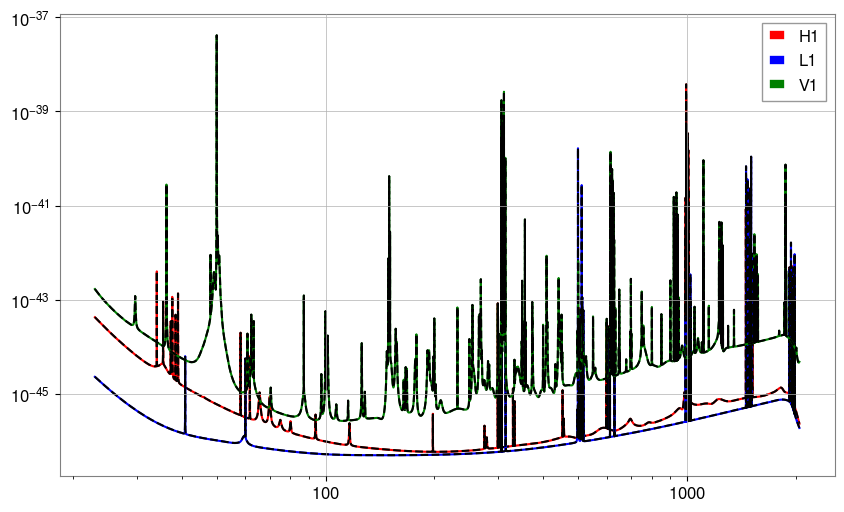

In [12]:
plt.figure(figsize=(10, 6))
for det, color in zip(["H", "L", "V"], ["red", "blue", "green"]):
    data_path = "/home/thibeau.wouters/gw-datasets/GW170817/" # on CIT
    file = f"{data_path}GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_{det}1_psd.txt"

    print(file)

    freq, psd = np.loadtxt(file, unpack=True)
    print("min(freq)")
    print(min(freq))
    plt.loglog(freq, psd, color = color, linestyle = "-", label = f"{det}1")
    
    file = f"{data_path}GW170817_{det.lower()}1_psd.txt"
    
    print(file)

    freq, psd = np.loadtxt(file, unpack=True)
    print("min(freq)")
    print(min(freq))
    plt.loglog(freq, psd, linestyle = "--", color = "black")
    
plt.legend()
plt.show()